Pontificia Universidad Católica de Chile <br>
Departamento de Ciencia de la Computación <br>
IIC3670 -	Procesamiento de Lenguaje Natural<br>
Segundo Semestre 2025<br>


<h1><center>Tarea 4: Simulación multi-agente con LangGraph </center></h1>
        Profesor: Marcelo Mendoza<br>
        Fecha de entrega: 30 de octubre


---

**Correo ayudante** (para dudas con el enunciado): javier.campos@uc.cl


## Contexto

En esta tarea implementarás paso a paso la **lógica de un juego social tipo *“Among Us”***, pero con una temática de **físicos y matemáticos famosos**.  
Cada ronda del juego sigue esta dinámica:

1. Se selecciona un **impostor** y un **científico secreto** al azar.
2. Los jugadores que son *crew* conocen el nombre del científico y deben dar **una pista inteligente**.
3. El impostor no conoce el nombre, pero debe fingir que sí.
4. Luego todos los jugadores discuten, **acusan y se defienden**.
5. Finalmente, cada jugador **vota** quién cree que es el impostor.
6. El juego termina cuando el impostor es descubierto o cuando quedan solo 2 jugadores.

Toda esta lógica será modelada como un **grafo de estados** utilizando [LangGraph](https://docs.langchain.com/oss/python/langgraph/quickstart).

---

## Qué es LangGraph (breve introducción)

LangGraph es una librería de Python que permite **orquestar LLMs y lógica personalizada** usando un modelo basado en **grafos dirigidos**.  
Los componentes principales son:

- **Estado (State):** estructura de datos compartida que se pasa entre nodos. Aquí usamos `GameState` para guardar toda la información de la partida (jugadores, rondas, votos, puntajes, etc.).  
- **Nodos (Nodes):** funciones puras que reciben un estado y devuelven un nuevo estado parcial. Cada etapa del juego (estrategia, pistas, declaraciones, votación, etc.) será un nodo.
- **Edges:** conexiones entre nodos. Permiten definir **el flujo secuencial** o **condicional** del juego (por ejemplo: si hay empate → volver a votar, si no → continuar).
- **Grafo (StateGraph):** estructura que conecta nodos y edges, define un punto de entrada y condiciones de enrutamiento, y luego **compila** una app ejecutable (`game_app`).
- **END:** nodo terminal especial que marca el fin del flujo.

---

##  Dinámica del juego a simular

Este juego tiene 5 jugadores con personalidades predefinidas.  
- 1 es **impostor**, 4 son **crew**.  
- En cada ronda:
  - Cada jugador dice **una palabra**.
  - Luego dice una **declaración** (acusación o defensa).
  - Todos **votan**.
  - Se eliminan jugadores y se suma puntaje según las reglas.
- Si el impostor es eliminado, **gana la crew**.  
- Si llegan a 2 jugadores, **gana el impostor**.  
- Después del juego, se genera un **análisis final** y **reflexiones individuales** (estos dos últimos pasos se dan como “regalo” en esta tarea 😉).



# Game Data

NO BORRAR; es clave para el funcionamiento de la tarea.

In [284]:
scientists = [
    "Albert Einstein",
    "Isaac Newton",
    "Galileo Galilei",
    "Marie Curie",
    "Niels Bohr",
    "Werner Heisenberg",
    "Erwin Schrödinger",
    "Richard Feynman",
    "Stephen Hawking",
    "Max Planck",
    "James Clerk Maxwell",
    "Michael Faraday",
    "Enrico Fermi",
    "Ernest Rutherford",
    "Paul Dirac",
    "Euclid",
    "Archimedes",
    "Carl Friedrich Gauss",
    "Leonhard Euler",
    "Gottfried Leibniz",
    "Pierre-Simon Laplace",
    "Évariste Galois",
    "Emmy Noether",
    "David Hilbert",
    "Kurt Gödel",
    "Srinivasa Ramanujan",
    "John von Neumann",
    "Alan Turing",
    "Henri Poincaré"
]

In [285]:
instrucciones = """
 In this game there are 5 players including you. One of them is an imposter, everyone else is part of the crew. Your role (imposter or crew) will be informed to you later.
 If you are crew, you will be provided with the name of a very famous, well-known physicist or mathematician. You must keep this name a secret at all costs.
 If you are the imposter, you will not be informed of this secret name, so you will have to guess it during the game.
 Every round of the game, every crew member has to say a word or short phrase related to the secret physicist/mathematician. IT CANNOT BE A WORD THAT HAS BEEN SAID PREVIOUSLY IN THE GAME.
 The imposter also has to say a word or short phrase trying to deceive the crew into thinking he knows the secret physicist/mathematician, either by lucky guessing or by inferring the secret based on the other players words.
 The job of every player is to say something good enough to convince every other player member you know the secret and are not an imposter.
 After everyone has said their word, now every player has to state who he thinks it's the imposter and/or state why he or other players are crew members.
 Once every player has spoken his mind and said his word realted to the secret physicist/mathematician, every player must reflect on the information and vote out the player they think its the imposter.
 The crew members have to correctly guess and vote out the imposter, minimizing the risk of voting out a fellow crew member.
 The imposter must try to guess the secret, say smart words and argue with mastery to try to fool the crew into voting out fellow crew members.
 After the voting, the most voted player gets kicked out. Every player left wins one point.
 If the imposter is kicked out, the game ends and the standing crew members win 2 points.
 If not, the game continues for another round.
 If the imposter reaches the final round, with only him and one other crew member left in the game, the game ends and the imposter wins 3 points.
 """

In [286]:
crew_strategy = """
Core Principle: Balance being helpful to other crew while avoiding giving the imposter too much information.
Key Tactics:

- Use specific but not obvious clues: Reference something only someone who truly knows the physicist would know, but not so obvious that the imposter can easily guess from it alone.
- Build on others' clues strategically: If another crew member gives a good clue, you can reference something related but different - this creates a web of connections the imposter can't fake.
- Watch for generic responses: The imposter will likely use vague, broadly applicable terms. Call out overly generic contributions.
- Use technical specificity: Reference specific theories, equations, years, or lesser-known facts that would be hard to guess.
- Create verification chains: Use clues that connect to previous rounds, making it harder for the imposter to keep up the facade.
"""

imposter_strategy ="""
Imposter Strategy
Core Principle: Gather information quickly while appearing knowledgeable.
Key Tactics:

- Start generic, get specific: Begin with broadly applicable terms (like "genius" or "theory") then narrow down based on others' clues.
- Piggyback intelligently: Listen to crew clues and build on them with related but safe terms that could apply to multiple physicists/mathematicians.
- Create false confidence: Act certain about your contributions and question others' clues to deflect suspicion.
- Use process of elimination: If you can identify the field (quantum physics, calculus, etc.) from early clues, focus your guesses there.
- Sow doubt strategically: Accuse others of being "too vague" or "suspicious" to redirect attention.
- Research common physics and math terms: Know enough general physics and math vocabulary to sound credible initially.
"""

# Installs

In [287]:
!pip install langgraph langchain langchain-openai

# LLM Setup


### 📍 Definir el LLM


> En este caso, el ejemplo es usando Claude Haiku, pero pueden utilizr cualuier proveedor dentro de langChain, incluyendo OpenAI, Google (que tiene API keys free tier) o correr pequeños modelos locales con Ollama o Huggingface.
> - Importar e instanciar el modelo `ChatAnthropic` desde `langchain_anthropic`.


> ⚠️ **Importante:** la API Key debe estar en la variable de entorno `ANTHROPIC_API_KEY`.

> ✨ *Ejemplo (estructura)*:
> ```python
> from langchain_anthropic import ChatAnthropic
> llm = ChatAnthropic(
>     model="claude-3-5-haiku-latest",
>     temperature=0.7,
>     max_tokens=1024,
>     timeout=None,
>     max_retries=2
> )
> ```



IMPORTANTE: Esto no lleva puntaje pero el simulador no funciona sin un LLM, por lo que es necesario ***revisar la documentación de LangChain y LangGraph para utilizar el modelo de su preferencia.***

Si tienes muchos problemas con esta parte no dudes en contactar al ayudante directamente al correo que aparece en el inicio de este notebook.

In [288]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(
    model="gpt-4.1-mini",
    temperature=0.7,
    max_tokens=1024,
    timeout=None,
    max_retries=2
)

In [289]:
from langchain.messages import HumanMessage, SystemMessage

messages = [
    HumanMessage(content="Hello, world!")
]

In [290]:
response = model.invoke(messages)
print(response.content)

Hello! How can I assist you today?


# State Definitions

A modo de ejemplo, definimos el `PlayerState` así:

In [291]:
from typing import TypedDict

class PlayerState(TypedDict):
    name: str
    traits: str
    strategy: str
    role: str
    in_game: bool
    points: int
    last_word: str
    last_statement: str
    voted_for: str
    vote_reasoning: str

### Player Definitions

Definimos a 5 simpáticos jugadores que nada tienen que ver con la realidad.

Siéntanse libres de crear sus propios 5 personajes y asignarles traits de personalidad

In [292]:
def create_player(name: str, traits: str) -> PlayerState:
    return PlayerState(
        name=name,
        traits=traits,
        strategy="",
        role="",
        in_game=False,
        points=0,
        last_word="",
        last_statement="",
        voted_for="",
        vote_reasoning=""
    )

In [293]:
# Define players with just name and traits
player_definitions = []

# player_definitions += [
#     ("Pavo Gallina", "competitive, outgoing, not so smart. Will accuse and defend himself strongly and very"),
#     ("La Víbora", "relaxed, kind of dumb, easily distracted. Will keep lo profile, no complex strategies"),
#     ("Deo TeLia", "Super competitive, smart and cool. A good liar and conman, can easily convice others with charisma"),
#     ("La Citroneta", "not competitive, very factual and calm. Will tell opinions firmly but keeping his cool."),
#     ("Alfonso CAB", "relaxed, analytical and factual. Will defend himself with well structured arguments and complex strategies to convince others")
# ]

player_definitions += [
    ("J.C. Bodoque", 
     "hides being competitive, outgoing, actually very smart. Uses charm and irony to manipulate others subtly. Plays for the fun of psychological chaos more than for winning. Often tests others’ logic with fake accusations or misleading jokes, just to see who bites."),
    ("Policarpo", 
     "competitive, smart, calm. Treats the game like an interview — asks questions, keeps mental notes, and builds neat narratives to convince others. Rarely shows emotion, but takes pride in being ‘the rational one’ and proving others wrong through logic."),
    ("Tulio Triviño", 
     "moderately competitive, not so smart, very outgoing. Loves attention and constantly talks over others, even when clueless. Convinced that confidence equals truth, he often leads wild accusations just to stay in the spotlight. Easily manipulated by flattery."),
    ("Mario Hugo", 
     "not competitive, kind, dreamy. Drifts through the game distractedly, occasionally saying something profound by accident. Prefers harmony over victory and will defend others out of empathy rather than reason. Often votes last, following whoever seems calmest."),
    ("Elemento", 
     "not competitive, loyal, emotional. Follows Mario Hugo’s lead almost blindly, mirroring his votes and suspicions. Gets defensive if Mario is accused and may lash out emotionally at his accusers. Rarely strategizes — acts purely on loyalty and impulse.")
]

# Create players dictionary
players = {name: create_player(name, traits) for name, traits in player_definitions}

---

### 📍  Definir la estructura de `GameState` (2 pts)

**Objetivo:** Crear la estructura de datos global que representará el estado completo del juego y se pasará entre nodos.

> 📝 Define un `TypedDict` llamado `GameState` que contenga al menos las siguientes claves:
> - `prev_rounds: str` — resumen acumulado de las rondas anteriores.
> - `current_round: str` — texto que describe la ronda actual.
> - `round: int` — número de ronda actual.
> - `players_order: list[str]` — orden en que los jugadores participan.
> - `imposter: str` — nombre del impostor.
> - `secret_scientist: str` — nombre del científico secreto.
> - `winner: str` — ganador del juego (`"crew"`, `"imposter"` o `None`).
> - `players: dict[str, PlayerState]` — estado de todos los jugadores (usa `PlayerState` ya definido).
> - `votes: dict[str, int]` — conteo de votos por jugador.
> - `revote_needed: bool` — indica si debe repetirse la votación.
> - `tied_players: list[str]` — jugadores empatados en una votación.
> - `game_over: bool` — indica si la partida terminó.
> - `game_summary: str` — análisis final de la partida.
> - `player_reflections: dict[str, str]` — reflexiones individuales de cada jugador.


---

In [294]:
from typing import TypedDict, NotRequired

class GameState(TypedDict):
    prev_rounds: str
    current_round: str
    round: int
    players_order: list[str]
    imposter: str
    secret_scientist: str
    winner: NotRequired[str]
    players: dict[str, PlayerState]
    votes: dict[str, int]
    revote_needed: bool
    tied_players: list[str]
    game_over: bool
    game_summary: str
    player_reflections: dict[str, str]

# Node Definitions

## 🧠 Qué vamos a implementar

Deberás completar las funciones y el flujo que permiten ejecutar la partida de principio a fin:

1. Inicialización del juego (`start_node`)
2. Definición de estrategias (`strategy_node`)
3. Generación de palabras (`generate_words_node`)
4. Generación de declaraciones (`generate_statements_node`)
5. Votación (`voting_node`)
6. Resolución de la ronda (`resolve_round_node`)
7. Routing y edges para conectar todo el flujo (`workflow`)


---


## 📍 1. `start_node`(4 pts)

**Objetivo:** inicializar el estado del juego seleccionando un impostor y un científico secreto al azar.

> 📝 Completa la función `start_node(state)` para que:
> - Cree una copia inicial del diccionario global `players`.
> - Seleccione aleatoriamente un impostor.
> - Seleccione aleatoriamente un científico secreto de la lista `scientists`.
> - Asigne el rol `"imposter"` al jugador elegido y `"crew"` al resto, activándolos en el juego (`in_game=True`).
> - Devuelva un diccionario que contenga todas las llaves necesarias de `GameState` inicializado correctamente.
>
> ⚠️ Tu implementación **debe mantener la misma estructura de `GameState` y `PlayerState`** usada en el resto del código. No se permite modificar las clases ni importar librerías adicionales.


---

In [295]:
import random
from langgraph.graph import StateGraph

def start_node(state: GameState):
    """
    TODO: Implementar inicialización del juego

    Pasos a seguir:
    1. Crear copia del diccionario global 'players'
    2. Seleccionar impostor aleatorio
    3. Seleccionar científico secreto aleatorio
    4. Asignar roles y activar jugadores (in_game=True, points=0)
    5. Crear lista de jugadores y mezclarla (random.shuffle)
    6. Retornar diccionario con todos los campos de GameState inicializados
    """

    players_copy = players.copy()
    imposter = random.choice(list(players_copy.keys()))
    secret_scientist = random.choice(scientists)

    # Inicializar estado de jugadores
    for name, player in players_copy.items():
        player['role'] = "imposter" if name == imposter else "crew"
        player["in_game"] = True
        player["points"] = 0

    players_list = list(players_copy.keys())
    random.shuffle(players_list)
    
    # Inicializar estado de juego
    state["prev_rounds"] = ""
    state["current_round"] = ""
    state["round"] = 1
    state["players_order"] = players_list
    state["imposter"] = imposter
    state["secret_scientist"] = secret_scientist
    state["winner"] = None
    state["players"] = players_copy
    state["votes"] = {name: 0 for name in players_list}
    state["revote_needed"] = False
    state["tied_players"] = []
    state["game_over"] = False
    state["game_summary"] = ""
    state["player_reflections"] = {name: "" for name in players_list}

    return state

## 📍 2. `strategy_node`(4 pts)

**Objetivo:** asignar estrategias a cada jugador según su rol o estrategia previamente aprendida.

> 📝 Completa la función `strategy_node(state, config=None)` para que:
> - Recorra todos los jugadores activos en `state["players"]`.
> - Si `config` contiene `"configurable" -> "character_strategies"`, usa esa estrategia para el jugador.
> - En caso contrario, utiliza `think_strategy.invoke({"role": player_role})` para obtener la estrategia base.
> - Devuelva un nuevo estado que actualice `strategy` para cada jugador.

---


In [296]:
from langchain.tools import tool

@tool
def think_strategy(role: str) -> str:
    """Retrieve strategy text based on player role."""
    if role == "crew":
        return crew_strategy
    elif role == "imposter":
        return imposter_strategy

In [297]:
def strategy_node(state: GameState, config=None):
    """
    TODO: Asignar estrategias a cada jugador

    Pasos a seguir:

    1. Para cada jugador, asignar estrategia (personalizada o por rol usando la tool definida arriba)
    2. Actualizar el campo 'strategy' de cada jugador
    3. Retornar estado actualizado con {"players": ...}
    """

    players = state["players"]

    character_strategies = None
    if config and "configurable" in config:
        character_strategies = config["configurable"].get("character_strategies") # dict por player name

    for player_name, player_state in players.items():
        if character_strategies and character_strategies.get(player_name):
            player_state["strategy"] = character_strategies[player_name]
        else:
            player_state["strategy"] = think_strategy.invoke({"role": player_state["role"]})
    
    return {"players": players}

## LEER CUIDADOSAMENTE

##  Ejemplos de patrones de nodos LLM

Antes de continuar, revisa estos patrones para comprender mejor cómo se hace prompting con el LLM en cada etapa:

-  `invoke`: 1 mensaje → 1 respuesta. (p. ej. `generate_words_node`)  
-  `batch`: varios mensajes → varias respuestas en paralelo. (p. ej. `generate_statements_node`)  
-  `with_structured_output`: respuesta estructurada con Pydantic. (p. ej. `voting_node`)

```python
# INVOKE
resp = model.invoke(messages)
text = resp.content.strip()

# BATCH
responses = model.batch(batch_messages)
texts = [r.content.strip() for r in responses]

# STRUCTURED
structured_model = model.with_structured_output(MyModel)
results = structured_model.batch(batch_messages)
```

---

## 📍 3. `generate_words_node`(10 pts)

**Objetivo:** cada jugador activo debe proponer una palabra o frase corta relacionada con el científico secreto.

> 📝 Completa la función `generate_words_node(state)` para que:
> - Recorra jugadores activos en `players_order`.
> - Construya el `context` con información del estado y del rol.
> - Llame `model.invoke(...)` y guarde la respuesta en `last_word`.
> - Actualice `current_round` concatenando líneas con el formato:
>   ```
>   Player {player_name}, (points: {points}) said: {word}
>   ```
> - Devuelva `{"players": ..., "current_round": ...}`.

---

In [298]:
def generate_words_node(state: GameState):
    players = state["players"]
    players_order = state["players_order"]
    updated_players = {**players}
    current_round_updates = []

    system_message = instrucciones
    """
    TODO: Generar palabras para cada jugador activo

    Pasos a seguir:
    1. Extraer todas las palabras previamente dichas usando regex
    2. Para cada jugador activo en players_order:
       - Determinar si es crew (mostrar científico) o impostor (ocultar)
       - Crear lista de palabras prohibidas
       - Construir prompt con contexto del juego
       - Llamar model.invoke(messages)
       - Guardar palabra en last_word
       - Agregar palabra al conjunto de palabras usadas
       - Crear entrada para current_round
    3. Retornar {"players": ..., "current_round": ...}

    Hint: Usa regex para extraer palabras de prev_rounds y current_round
    Pattern sugerido: r"(?:Player\s+)?([^:,]+?)(?:\s*\(points:\s*\d+\))?\s*(?:said:?\s*|:)\s*([^\n\|]+?)(?:\s*\||$)"
    """
    # Completar aquí
    
    import re
    previous_words = re.findall(r"(?:Player\s+)?([^:,]+?)(?:\s*\(points:\s*\d+\))?\s*(?:said:?\s*|:)\s*([^\n\|]+?)(?:\s*\||$)", state["prev_rounds"] + " " + state["current_round"])
    used_words = {word for player, word in previous_words}

    for player_name in players_order:
        player_state = players[player_name]

        if not player_state["in_game"]:
            continue

        if player_state["role"] == "crew":
            secret_info = f"The secret physicist/mathematician is: {state['secret_scientist']}."
        else:
            secret_info = "You are the imposter. You do not know the secret physicist/mathematician."

        context_prompt = f"""
            You are playing a game where you have to say a word related to a secret physicist/mathematician.
            {secret_info}

            Your traits are: {player_state['traits']}
            Your strategy is: {player_state['strategy']}
            Previous rounds words said (do not repeat any of these): {', '.join(used_words) if used_words else 'None'}.

            **Your task:**
            Provide a single word related to the secret physicist/mathematician that has not been said before.

        """

        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=context_prompt)
        ]

        response = model.invoke(messages)
        word = response.content.strip()
        player_state["last_word"] = word
        used_words.add(word)
        current_round_updates.append(f"{player_name}: {word}")
        
        updated_players[player_name] = player_state

    return {
        "players": updated_players,
        "current_round": " | ".join(current_round_updates)
    }
    

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_62501/2006905177.py:8: SyntaxWarning: invalid escape sequence '\s'
  """


## 📍 4. `generate_statements_node`(10 pts)

**Objetivo:** cada jugador debe generar una declaración corta (acusación y/o defensa) en paralelo.

> 📝 Completa la función `generate_statements_node(state)` para que:
> - Prepare un batch de mensajes para todos los jugadores activos.
> - Llame `model.batch(...)` y guarde las respuestas en `last_statement`.
> - Agregue un bloque `--- STATEMENTS ---` con las declaraciones al `current_round`.
> - Devuelva `{"players": ..., "current_round": ...}`.

---


In [299]:
def generate_statements_node(state: GameState):
    """
    TODO: Generar declaraciones (acusaciones/defensas) en paralelo

    Pasos a seguir:
    1. Crear lista de contextos (player_contexts) para batch
    2. Para cada jugador activo:
       - Construir prompt con información de ronda
       - Agregar messages al batch
    3. Llamar model.batch(player_contexts)
    4. Guardar cada respuesta en last_statement
    5. Crear bloque "--- STATEMENTS ---"
    6. Retornar {"players": ..., "current_round": ...}

    Hint: Usa model.batch() para procesar todos los jugadores en paralelo
    """
    players = state["players"]
    players_order = state["players_order"]
    updated_players = {**players}

    system_message = instrucciones

    player_contexts = []
    active_players = []

    for player_name in players_order:
        player_state = players[player_name]

        if not player_state["in_game"]:
            continue
        
        context_prompt = f"""
            You are {player_name}.
            You are at the point in the game where you have to make an accusation or defend yourself about being the imposter.
            Your traits are: {player_state['traits']}
            Your strategy is: {player_state['strategy']}
            Previous rounds words said: {state['prev_rounds'] + ' ' + state['current_round']}.

            **Your task:**
            Provide a statement explaining who you think is the imposter and/or why you are a crew member.

        """

        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=context_prompt)
        ]

        player_contexts.append(messages)
        active_players.append(player_name)
    
    responses = model.batch(player_contexts)

    for player_name, response in zip(active_players, responses):
        player_state = players[player_name]
        player_state["last_statement"] = response.content.strip()
        updated_players[player_name] = player_state

    statements = [f"{player_name}: {player_state['last_statement']}" for player_name, player_state in updated_players.items() if player_state["in_game"]]

    return {
        "players": updated_players,
        "current_round": state["current_round"] + "\n" + "\n".join(statements)
    }

## 📍 5. `voting_node`(10 pts)

**Objetivo:** cada jugador debe votar por quién cree que es el impostor usando **structured output**.

> 📝 Completa la función `voting_node(state)` para que:
> - Defina el modelo Pydantic `Vote` con `player_name` y `reasoning`.
> - Construya prompts diferentes para revote y para ronda normal.
> - Llame `model.with_structured_output(Vote).batch(...)`.
> - Acumule votos y los guarde en `votes`.
> - Devuelva `{"players": ..., "votes": ...}`.

Aclaración: En caso de  empate, hay revote y los jugadores deben saber que esta situación ocurrió y su opciones de votación estan restringidas solo a aquellos jugadores empatados.
Notar que ningún jugador puede votar por si mismo para ser eliminado.

---

In [300]:
from pydantic import BaseModel, Field

class Vote(BaseModel):
    player_name: str = Field(description="The exact name of the player you vote to eliminate.")
    reasoning: str = Field(description="Brief explanation (1-2 sentences) of why you're voting for this player")


In [322]:
def voting_node(state: GameState):
    """
    TODO: Procesar votación con structured output

    Pasos a seguir:
    1. Para cada jugador:
       - Determinar jugadores votables
       - Construir prompt (diferente para revote vs normal)
       - Agregar al batch
    2. Llamar model.with_structured_output(Vote).batch(...)
    3. Acumular votos en diccionario votes
    4. Guardar voted_for y vote_reasoning
    5. Retornar {"players": ..., "votes": ...}

    Hint: usa el modelo Pydantic Vote (ya definido arriba)
    """

    players = state["players"]
    players_order = state["players_order"]
    updated_players = {**players}

    active_players_list = [p for p in players_order if players[p]["in_game"]]

    is_revote = state.get("revote_needed", False)
    tied_players = state.get("tied_players", [])

    system_message = instrucciones

    player_contexts = []
    voting_players = []

    # Completar aquí

    for player_name in active_players_list:
        player_state = players[player_name]

        candidate_players = active_players_list if not is_revote else tied_players
        votable_players = [p for p in candidate_players if p != player_name]

        if is_revote:
            context_prompt = f"""
                You are {player_name}.
                You are in a revote situation in the game. You must vote again between the tied players to eliminate the imposter.
                Your traits are: {player_state['traits']}
                Your strategy is: {player_state['strategy']}
                Previous rounds words said: {state['prev_rounds'] + ' ' + state['current_round']}.

                **Your task:**
                Choose one of the following players to vote out: {', '.join(votable_players)}. You CANNOT vote for yourself.
                Provide your vote and a brief reasoning (1-2 sentences) for your choice.

            """
        else:
            context_prompt = f"""
                You are at the voting stage of the game. You must vote to eliminate the player you believe is the imposter.
                Your traits are: {player_state['traits']}
                Your strategy is: {player_state['strategy']}
                Previous rounds words said: {state['prev_rounds'] + ' ' + state['current_round']}.

                **Your task:**
                Choose one of the following players to vote out: {', '.join(votable_players)}.
                Provide your vote and a brief reasoning (1-2 sentences) for your choice.

            """
        messages = [
            SystemMessage(content=system_message),
            HumanMessage(content=context_prompt)
        ]
        player_contexts.append(messages)
        voting_players.append(player_name)
    
    responses = model.with_structured_output(Vote).batch(player_contexts)
    votes_count = {name: 0 for name in active_players_list}
    for player_name, response in zip(voting_players, responses):
        player_state = players[player_name]
        voted_for = response.player_name
        reasoning = response.reasoning

        player_state["voted_for"] = voted_for
        player_state["vote_reasoning"] = reasoning
        updated_players[player_name] = player_state

        if voted_for in votes_count:
            votes_count[voted_for] += 1

    return {
        "players": updated_players,
        "votes": votes_count
    }

## 📍 6. `resolve_round_node` (10 pts)

**Objetivo:** cerrar la ronda, manejar empates, eliminar jugadores, sumar puntos y detectar ganador.

> 📝 Completa la función `resolve_round_node(state)` para que:
> - Si hay empate, devuelva un estado con `revote_needed=True` y los empatados en `tied_players`.
> - Si no hay empate, elimine al más votado y genere un resumen de ronda (Words, Statements, Votes).
> - Sume puntos según el resultado:
>   - Impostor eliminado → crew gana (2 puntos)
>   - Solo 2 jugadores → impostor gana (3 puntos)
>   - Ronda normal → +1 punto a los activos
> - Devuelva el estado actualizado y limpio para la siguiente ronda.

---

In [302]:
def resolve_round_node(state: GameState):
    players = state["players"]
    votes = state["votes"]
    players_order = state["players_order"]
    current_round_num = state["round"]
    """
    TODO: Resolver ronda, manejar empates, eliminar jugadores, asignar puntos

    Pasos a seguir:
    1. Encontrar jugador(es) con más votos
    2. Si hay empate (len(most_voted) > 1):
       - Retornar con revote_needed=True y tied_players
    3. Si no hay empate:
       - Eliminar jugador más votado (in_game=False)
       - Crear resumen de ronda (words, statements, votes) y agregar a prev_rounds
       - Verificar condiciones de victoria:
         * Impostor eliminado → crew gana (+2 puntos crew)
         * Solo 2 jugadores → impostor gana (+3 puntos impostor)
         * Continuar → +1 punto a activos
       - Limpiar current_round y actualizar round number
    4. Retornar estado actualizado

    Hint: Usa max(votes.values()) para encontrar votos máximos
    """
    # Completar aquí

    max_votes = max(votes.values())
    most_voted = [name for name, count in votes.items() if count == max_votes]
    
    if len(most_voted) > 1:
        return {
            "revote_needed": True,
            "tied_players": most_voted
        }
    else:
        eliminated_player_name = most_voted[0]
        eliminated_player = players[eliminated_player_name]
        eliminated_player["in_game"] = False

        # Crear resumen estructurado simple
        current_lines = state["current_round"].split("\n")
        current_words = current_lines[0]  # Primera línea son las palabras
        current_statements = "\n".join(current_lines[1:]) if len(current_lines) > 1 else ""  # Todas las líneas después de la primera son statements
        
        # Crear sección de votos
        vote_list = []
        for name in players_order:
            player_state = players[name]
            if player_state["in_game"] or name == eliminated_player_name:
                vote_list.append(f"{name} voted for {player_state['voted_for']}")
        
        # Determinar rol del eliminado
        eliminated_role = "crew" if eliminated_player_name != state["imposter"] else "imposter"
        
        # Crear lista de jugadores restantes
        remaining_players = [name for name, p in players.items() if p["in_game"]]
        
        # Construir resumen completo
        round_summary = f"--- ROUND {current_round_num} SUMMARY ---\n"
        round_summary += f"Words: {current_words}\n"
        round_summary += f"Statements: {current_statements}\n"
        round_summary += f"Votes: {' | '.join(vote_list)}\n"
        round_summary += f"Eliminated: {eliminated_player_name} ({max_votes} votes) - Role was: {eliminated_role}\n"
        round_summary += f"Remaining players: {remaining_players}\n"

        updated_prev_rounds = state["prev_rounds"] + round_summary + "\n"

        # Si el impostor es eliminado
        if eliminated_player_name == state["imposter"]:
            for player_name, player_state in players.items():
                if player_state["in_game"]:
                    player_state["points"] += 2
            return {
                "players": players,
                "prev_rounds": updated_prev_rounds,
                "game_over": True,
                "winner": "crew"
            }
        else:
            active_players = [name for name, p in players.items() if p["in_game"]]
            # Si quedan 2 jugadores con el impostor -> impostor gana
            if len(active_players) == 2:
                imposter_name = state["imposter"]
                imposter_state = players[imposter_name]
                imposter_state["points"] += 3
                return {
                    "players": players,
                    "prev_rounds": updated_prev_rounds,
                    "game_over": True,
                    "winner": "imposter"
                }
            # Si el juego continúa
            else:
                for player_name in active_players:
                    players[player_name]["points"] += 1
                return {
                    "players": players,
                    "prev_rounds": updated_prev_rounds,
                    "round": state["round"] + 1,
                    "current_round": "",
                    "players_order": active_players,
                    "votes": {name: 0 for name in active_players},
                    "revote_needed": False,
                    "tied_players": []
                }

## Nodos "de regalo"

Los definimos para que todos tengan comportamientos similares, además sirven de ejemplo para trabajar con states dicts dentro de nodos que hacen llmadas a un LLM.

In [303]:
def post_game_summary_node(state):
    """Generate comprehensive post-game analysis with per-player performance paragraphs."""
    players = state["players"]
    imposter_name = state["imposter"]
    secret_scientist = state["secret_scientist"]
    winner = state["winner"]

    # Get ALL players (including eliminated ones) sorted by points descending
    all_player_names = sorted(players.keys(), key=lambda name: players[name]['points'], reverse=True)

    # Build final points summary
    final_scores = []
    for player_name in all_player_names:
        player_state = players[player_name]
        role_reveal = "IMPOSTER" if player_name == imposter_name else "CREW"
        status = "SURVIVED" if player_state["in_game"] else "ELIMINATED"
        final_scores.append(f"{player_name} ({role_reveal}, {status}): {player_state['points']} points")

    analysis_prompt = f"""
    You are analyzing a completed game of Imposter. Review the entire game history and provide a comprehensive post-game analysis.

    **Game Overview:**
    - Secret Scientist: {secret_scientist}
    - Imposter: {imposter_name}
    - Winner: {winner.upper()}
    - Final Scores: {', '.join(final_scores)}

    **Complete Game History:**
    {state["prev_rounds"]}

    **Your Task:**
    Generate a post-game analysis with the following structure:

    1. **Game Overview** (2-3 sentences): Why did the {winner} win? What were the key turning points?

    2. **Individual Player Analysis** (one paragraph per player):
       For each player below, write ONE focused paragraph analyzing:
       - Specific words/statements they made and their effectiveness
       - Critical moments where they influenced the game (positively or negatively)
       - What worked well in their approach
       - What mistakes they made or what they could have done differently
       - How well they followed their role's objectives
       - For eliminated players: why they were eliminated and what they could have done to survive

    Players to analyze (in this exact order):
    {chr(10).join([f"- {name}" for name in all_player_names])}

    **Format Requirements:**
    - Start each player's paragraph with "**[Player Name]:**"
    - Be specific - reference actual words, votes, and moments from the game
    - Focus on actionable insights they can learn from
    - Keep each paragraph to 4-6 sentences
    - Use concrete examples from the game history
    - IMPORTANT: Analyze ALL players, including those who were eliminated

    Generate the complete analysis now.
    """

    messages = [
        ("system", "You are an expert game analyst providing constructive feedback to help players improve their strategy."),
        ("user", analysis_prompt)
    ]

    response = model.invoke(messages)
    game_summary = response.content.strip()

    return {
        "game_summary": game_summary
    }

In [304]:
def individual_reflections_node(state):
    players = state["players"]
    game_summary = state["game_summary"]
    updated_players = {**players}

    # Get ALL players (including eliminated ones)
    all_player_names = list(players.keys())

    player_paragraphs = {}

    for player_name in all_player_names:
        import re
        pattern = rf"\*\*{re.escape(player_name)}:?\*\*\s*(.*?)(?=\*\*[A-Z]|$)"
        match = re.search(pattern, game_summary, re.DOTALL | re.IGNORECASE)

        if match:
            player_paragraphs[player_name] = match.group(1).strip()
        else:
            player_paragraphs[player_name] = f"[Full game analysis provided]\n{game_summary}"

    reflection_contexts = []
    reflecting_players = []

    for player_name in all_player_names:
        player_state = players[player_name]
        player_paragraph = player_paragraphs.get(player_name, "No specific feedback available.")

        # Indicate if player was eliminated
        survival_status = "You survived until the end." if player_state["in_game"] else "You were eliminated during the game."

        reflection_prompt = f"""
        You just finished a game of Imposter. Here is the post-game analysis about YOUR performance:

        {player_paragraph}

        **Your Information:**
        - Name: {player_name}
        - Personality traits: {player_state["traits"]}
        - Role you played: {player_state["role"]}
        - Your current strategy: {player_state["strategy"]}
        - Final points: {player_state["points"]}
        - Game outcome: {survival_status}

        **Your Task:**
        Based on the analysis of your performance, reflect on what you learned and write an UPDATED strategy for future games.

        Consider:
        - What specific moments from the analysis show what worked or didn't work?
        - How can you adjust your approach based on these insights?
        - What should you do differently next time in a similar role?
        - If you were eliminated, what red flags did you raise that led to your elimination?

        **Format Requirements:**
        Write a brief updated strategy (3-4 bullet points, each 1 sentence long).
        Focus on actionable tactics you'll use in future games.
        Incorporate lessons learned from this game's analysis.

        Example format:
        • [Specific tactic based on what you learned]
        • [Another actionable strategy point]
        • [Third tactical adjustment]
        • [Optional fourth point if needed]

        Generate ONLY the bullet points, nothing else.
        """

        messages = [
            ("system", f"You are {player_name}, a player reflecting on your game performance with your personality: {player_state['traits']}"),
            ("user", reflection_prompt)
        ]

        reflection_contexts.append(messages)
        reflecting_players.append(player_name)

    reflection_responses = model.batch(reflection_contexts)

    player_reflections = {}
    for player_name, response in zip(reflecting_players, reflection_responses):
        player_state = players[player_name]

        reflection_text = response.content.strip()
        player_reflections[player_name] = reflection_text

        updated_players[player_name] = {
            **player_state,
            "strategy": reflection_text
        }

    return {
        "players": updated_players,
        "player_reflections": player_reflections
    }

# Routing & Graph Building

In [305]:
def route_after_resolve(state):
    """Conditional edge function to determine next step after resolving round."""
    if state.get("revote_needed", False):
        return "revote"
    elif state.get("game_over", False):
        return "post_game"
    else:
        return "continue"

## 📍 7.Routing y Edges(10 pts)

**Objetivo:** conectar todos los nodos implementados en un grafo funcional de LangGraph.

 📝 Pasos a seguir

1. Crear `StateGraph(GameState)`
2. Agregar todos los nodos:
   - `start`, `strategy`, `generate_words`, `generate_statements`, `voting`, `resolve_round`
   - `post_game_summary`, `individual_reflections`
3. Establecer entry point en "start"
4. Conectar edges secuenciales:
   - `start` → `strategy`
   - `strategy` → `generate_words`
   - `generate_words` → `generate_statements`
   - `generate_statements` → `voting`
   - `voting` → `resolve_round`
5. Agregar conditional edges desde `resolve_round`:
   - "revote" → "voting"
   - "continue" → "generate_words"
   - "post_game" → "post_game_summary"
6. Conectar post-game:
   - `post_game_summary` → `individual_reflections`
   - `individual_reflections` → `END`
7. Compilar: `game_app = workflow.compile()`


In [323]:
# Build the game graph
from langgraph.graph import END, START

"""
TODO: Construir el grafo completo del juego
"""
workflow = StateGraph(GameState)

# Completar aquí
workflow.add_node("start", start_node)
workflow.add_node("strategy", strategy_node)
workflow.add_node("generate_words", generate_words_node)
workflow.add_node("generate_statements", generate_statements_node)
workflow.add_node("voting", voting_node)
workflow.add_node("resolve_round", resolve_round_node)
workflow.add_node("post_game_summary", post_game_summary_node)
workflow.add_node("individual_reflections", individual_reflections_node)

workflow.add_edge(START, "start")
workflow.add_edge("start", "strategy")
workflow.add_edge("strategy", "generate_words")
workflow.add_edge("generate_words", "generate_statements")
workflow.add_edge("generate_statements", "voting")
workflow.add_edge("voting", "resolve_round")

workflow.add_conditional_edges("resolve_round", route_after_resolve, {
    "revote": "voting",
    "continue": "generate_words",
    "post_game": "post_game_summary"
})

workflow.add_edge("post_game_summary", "individual_reflections")
workflow.add_edge("individual_reflections", END)
    
# Compilar
game_app = workflow.compile()

<unknown>:8: SyntaxWarning: invalid escape sequence '\s'


### Visualize Graph



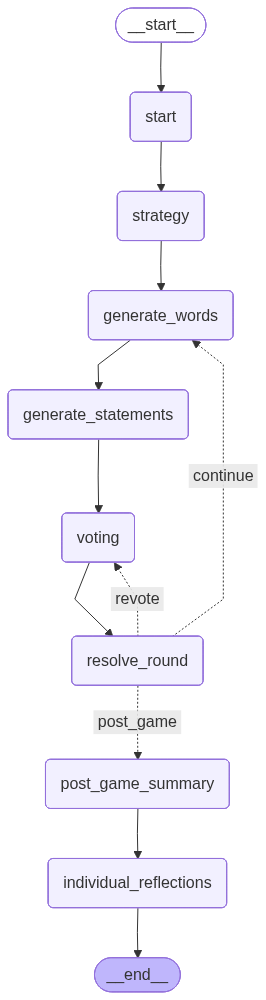

In [324]:
from IPython.display import Image, display
display(Image(game_app.get_graph().draw_mermaid_png()))

# Multi-Game Simulation

Con el siguiente codigo podemos correr la simulación y ver como interactuan los agentes en el juego


In [325]:
import json
from datetime import datetime

def initialize_character_strategies():
    character_strategies = {}

    for player_name in players.keys():
        character_strategies[player_name] = None

    return character_strategies

def run_single_game(game_number, character_strategies=None):
    """Run a single game and return results with updated strategies.

    Args:
        game_number: The game iteration number
        character_strategies: Optional dict of evolved strategies to use

    Returns:
        dict: Game results including final state and statistics
    """
    print(f"\n{'='*60}")
    print(f"Starting Game #{game_number}")
    print(f"{'='*60}")

    config = {
        "configurable": {
            "character_strategies": character_strategies
        }
    } if character_strategies else None

    if config:
        final_state = game_app.invoke({}, config=config)
    else:
        final_state = game_app.invoke({})

    game_stats = {
        "game_number": game_number,
        "winner": final_state["winner"],
        "imposter": final_state["imposter"],
        "secret_scientist": final_state["secret_scientist"],
        "total_rounds": final_state["round"],
        "final_scores": {},
        "updated_strategies": {}
    }

    for player_name, player_state in final_state["players"].items():
        game_stats["final_scores"][player_name] = player_state["points"]
        game_stats["updated_strategies"][player_name] = player_state["strategy"]

    print(f"\n--- Game #{game_number} Results ---")
    print(f"Winner: {final_state['winner'].upper()}")
    print(f"Imposter was: {final_state['imposter']}")
    print(f"Secret Scientist: {final_state['secret_scientist']}")
    print(f"Rounds played: {game_stats['total_rounds']}")
    print(f"\nFinal Scores:")
    for player_name, points in game_stats["final_scores"].items():
        role = "IMPOSTER" if player_name == final_state["imposter"] else "CREW"
        print(f"  {player_name} ({role}): {points} points")

    if final_state.get("game_summary"):
        print(f"\n--- Post-Game Analysis ---")
        print(final_state["game_summary"])

    if final_state.get("player_reflections"):
        print(f"\n--- Player Reflections & Updated Strategies ---")
        for player_name, reflection in final_state["player_reflections"].items():
            print(f"\n{player_name}:")
            print(reflection)

    return game_stats, final_state

In [326]:
import json
from datetime import datetime

def run_simulation(num_games=5, output_file="simulation_results.json"):
    """Run multiple games with strategy evolution.

    Args:
        num_games: Number of games to run
        output_file: Path to save results JSON
    """
    print(f"\n{'#'*60}")
    print(f"Starting Multi-Game Simulation: {num_games} games")
    print(f"{'#'*60}")

    character_strategies = initialize_character_strategies()
    all_game_stats = []
    cumulative_stats = {
        "total_games": num_games,
        "crew_wins": 0,
        "imposter_wins": 0,
        "player_stats": {
            player_name: {
                "total_points": 0,
                "games_as_crew": 0,
                "games_as_imposter": 0,
                "times_eliminated": 0,
                "times_survived": 0
            }
            for player_name in players.keys()
        }
    }

    for game_num in range(1, num_games + 1):
        game_stats, final_state = run_single_game(game_num, character_strategies)

        all_game_stats.append(game_stats)

        if game_stats["winner"] == "crew":
            cumulative_stats["crew_wins"] += 1
        else:
            cumulative_stats["imposter_wins"] += 1

        for player_name, player_state in final_state["players"].items():
            player_stats = cumulative_stats["player_stats"][player_name]
            player_stats["total_points"] += player_state["points"]

            if player_name == final_state["imposter"]:
                player_stats["games_as_imposter"] += 1
            else:
                player_stats["games_as_crew"] += 1

            if player_state["in_game"]:
                player_stats["times_survived"] += 1
            else:
                player_stats["times_eliminated"] += 1

        for player_name in players.keys():
            if player_name in game_stats["updated_strategies"]:
                strategy = game_stats["updated_strategies"][player_name]
                if strategy:
                    character_strategies[player_name] = strategy

    print(f"\n{'#'*60}")
    print(f"SIMULATION COMPLETE - Summary of {num_games} Games")
    print(f"{'#'*60}")
    print(f"\nOverall Results:")
    print(f"  Crew Wins: {cumulative_stats['crew_wins']} ({cumulative_stats['crew_wins']/num_games*100:.1f}%)")
    print(f"  Imposter Wins: {cumulative_stats['imposter_wins']} ({cumulative_stats['imposter_wins']/num_games*100:.1f}%)")

    print(f"\nPlayer Statistics Across All Games:")
    for player_name, stats in cumulative_stats["player_stats"].items():
        print(f"\n{player_name}:")
        print(f"  Total Points: {stats['total_points']}")
        print(f"  Average Points/Game: {stats['total_points']/num_games:.2f}")
        print(f"  Games as Crew: {stats['games_as_crew']}")
        print(f"  Games as Imposter: {stats['games_as_imposter']}")
        print(f"  Survival Rate: {stats['times_survived']/num_games*100:.1f}%")

    print(f"\nFinal Evolved Strategies:")
    for player_name, strategy in character_strategies.items():
        if strategy:
            print(f"\n{player_name}:")
            print(strategy)
        else:
            print(f"\n{player_name}: [Using default strategy]")

    results = {
        "simulation_metadata": {
            "num_games": num_games,
            "timestamp": datetime.now().isoformat(),
        },
        "cumulative_stats": cumulative_stats,
        "all_games": all_game_stats,
        "final_strategies": character_strategies
    }

    with open(output_file, 'w', encoding='utf-8') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

    print(f"\n{'='*60}")
    print(f"Results saved to: {output_file}")
    print(f"{'='*60}")

    return results

## Ejemplos de Uso del Simulador
Vamos a ejecutar ambas versiones para ver los cambios en las estrategias y el resumen general de juego.

### 1. Un solo juego

In [327]:
character_strategies = initialize_character_strategies()

In [318]:
game_stats, final_state = run_single_game(game_number=1, character_strategies=character_strategies)


Starting Game #1

--- Game #1 Results ---
Winner: CREW
Imposter was: Elemento
Secret Scientist: John von Neumann
Rounds played: 2

Final Scores:
  J.C. Bodoque (CREW): 3 points
  Policarpo (CREW): 3 points
  Tulio Triviño (CREW): 3 points
  Mario Hugo (CREW): 0 points
  Elemento (IMPOSTER): 1 points

--- Post-Game Analysis ---
**Game Overview:**  
The crew won by maintaining a consistent focus on specific, interconnected clues that aligned closely with the secret scientist John von Neumann’s multidimensional legacy in physics, mathematics, and computing. Key turning points included the successful identification and elimination of Mario Hugo in Round 1 based on his more generic clue "Automata" and the unanimous and well-reasoned vote to eliminate Elemento in Round 2, whose vague clue "Theory" failed to integrate convincingly with the other players’ technical and precise references.

**J.C. Bodoque:**  
J.C. Bodoque effectively anchored his clues around "Quantum," a central theme that s

In [319]:
for key, value in game_stats.items():
    print(f"{key}: {value}")

game_number: 1
winner: crew
imposter: Elemento
secret_scientist: John von Neumann
total_rounds: 2
final_scores: {'J.C. Bodoque': 3, 'Policarpo': 3, 'Tulio Triviño': 3, 'Mario Hugo': 0, 'Elemento': 1}
updated_strategies: {'J.C. Bodoque': '• Preemptively address potential doubts about broad clues by immediately clarifying their specific relevance to avoid deflection attempts.  \n• Continue using interconnected, specific references that build on others’ clues to create complex verification chains imposter players struggle to mimic.  \n• Subtly call out generic or vague contributions early to pressure imposters into revealing inconsistent logic or hesitation.  \n• Incorporate ironic or misleading jokes strategically to test others’ reactions without compromising key information.', 'Policarpo': '• Exercise greater caution before expressing early suspicions to avoid fracturing trust; prioritize gathering more evidence before targeting individuals.  \n• Continue leveraging highly specific, te

In [320]:
for key, value in final_state.items():
    print(f"{key}: {value}")

prev_rounds: --- ROUND 1 SUMMARY ---
Words: Tulio Triviño: Game start! My word is: "Princeton" | Elemento: Relativity | Mario Hugo: Automata | Policarpo: Von Neumann architecture | J.C. Bodoque: Quantum
Statements: J.C. Bodoque: Ah, the tangled webs we weave! Let's take a moment to appreciate the subtle dance of clues here. Tulio kicked off with "Princeton," a place tied to our mystery physicist’s later career. Elemento brought up "Relativity," which, while fundamental, is somewhat broad. Mario Hugo’s "Automata" and Policarpo’s "Von Neumann architecture" delve into computing theory, which might be a tempting red herring or a clever nod to the mathematician’s influence beyond physics.

Now, my "Quantum" is purposely chosen—not just a buzzword but a domain where the secret figure made crucial contributions, beyond just relativity or classical mechanics.

Looking closely, Mario Hugo’s "Automata" stands out as the most generic of the computing terms; it could be anyone guessing or fishing 

Podemos ver las personalidades y rasgos de los personajes en juego. Hay personajes inteligentes que saben exactamente lo que está pasando, como Bodoque, incluso "provocando" reacciones del resto para identificar más fácilmente al impostor. Fue el único que había identificado originalmente a Elemento como el impostor. 

Al mismo tiempo, todos los que conocen al científico "saben mucho". Incluso para los personajes más "tontos" como Tulio entienden inmediatamente las referencias específicas al trabajo de este científico. Por esto, es difícil para el impostor ganar, pues el resto suele elegir términos específicos inmediatamente... excepto cuando no lo hacen --como en la primera ronda con Mario Hugo, donde fue eliminado antes que Elemento incluso.

### 2. Ejecutar una simulación de múltiples partidas (con evolución de estrategias)

Considera que toma aprox 1 minuto por ronda

In [328]:
results = run_simulation(num_games=3, output_file="simulation_results.json")


############################################################
Starting Multi-Game Simulation: 3 games
############################################################

Starting Game #1

--- Game #1 Results ---
Winner: CREW
Imposter was: Elemento
Secret Scientist: Enrico Fermi
Rounds played: 2

Final Scores:
  J.C. Bodoque (CREW): 3 points
  Policarpo (CREW): 0 points
  Tulio Triviño (CREW): 3 points
  Mario Hugo (CREW): 3 points
  Elemento (IMPOSTER): 1 points

--- Post-Game Analysis ---
1. **Game Overview:**  
The crew secured victory by collectively weaving a coherent narrative around Enrico Fermi’s legacy, using specific, historically grounded terms like “Chicago,” “Neutron,” “Beta decay,” and “Chain reaction.” The key turning points were the unanimous suspicion and elimination of Policarpo in Round 1, who was misjudged due to perceived vagueness, and the decisive identification and elimination of Elemento in Round 2, whose attempts to blend in with broader terms like “Quantum” and “Fis

Curiosamente, en esta simulación, Tulio resultó ser el jugador más fuerte en lugar de Bodoque, y con diferencia. Logró un survival rate de 100% incluyendo una victoria como impostor, y 11 puntos a lo largo de los 3 juegos. Bodoque y Mario Hugo, que le siguen, lograron 6 y 7 puntos respectivamente. Al ser eliminados tempranamente, no lograron maximizar sus puntos como Tulio, incluso cuando tuvieron estrategias buenas.

Incluso, desde los comentarios finales sobre estrategias, vemos que:
- Bodoque fue demasiado ácido e irónico, a la vez que no logró defender correctamente sus decisiones. Fue muy "sabelotodo" pero sin la parte de saberlo todo.
- Poli sufrió de pasividad. No interactuó de forma suficientemente proactiva, lo que le hizo perderse de algunas cosas y construir alianzas que le den una mejor posibilidad de sobrevivir. Al mismo tiempo, no eligió buenos términos y en general no estuvo tan "involucrado" como otros jugadores. De hecho, nunca fue elegido como impostor, pero aún así llegó al final una sola vez.
- Tulio tuvo algo de suerte: Sus comentarios indican varias áreas a mejorar, incluyendo formas poco óptimas de interactuar y construir confianza. No obstante, sus decisiones de palabras fueron buenas, y le permitieron llegar al final incluso como impostor. 
- Mario Hugo es menos seguro de sí mismo, lo cual tuvo sus pros y contras: Por un lado, significa que su pasividad no resalta como una posible hostilidad, lo cuál le permite pasar por debajo del radar del resto frente a otros jugadores más polémicos. Por otra parte, no confía suficientemente en su propio criterio incluso cuando es acertado, y se deja llevar por la opinión de los demás, lo que le lleva a tomar malas decisiones en la votación.
- Elemento: El mayor punto en contra en la estrategia de elemento es su lealtad ciega a Mario Hugo. Esto le impide alinearse con el resto del grupo y votar de forma racional. En general, su estrategia es mucho más defensiva que la del resto, y es más reactiva, lo que entendiblemente levanta sospechas del resto del grupo.

#### Nota final:
Estuvo muy entretenida esta tarea! Poder hacer un mini-cast de 31 minutos para jugar fue genial.

Gracias a su escritor :)